In [4]:
import pandas as pd
import geopandas as gpd
import requests
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Using cleaned csv data

This repo runs through how to read csv data stroed in the `data/interim` folder. Asseses the relationship between covid deaths and the ethnic diversity of a region.

In [20]:
covid_df= pd.read_csv("../data/interim/clean_fbook_covid_deaths.csv", index_col=4)
ethnicity_df= pd.read_csv("../data/interim/clean_ethnicity_2011.csv", index_col=1)

## Joining race and covid deaths
Joining the 2 data sets also allows us to create a normalised death rate. However it is normalised by 2011 census data, but will give an indication of the more populated Local Authority Districts.

In [61]:
df = covid_df.join(ethnicity_df) # join the deaths and ethnicity data by local authority
df = df[list(df.columns[33:])] # only take the latest figures

df[df.columns[1]] = df[df.columns[0]]/df["Denominator"] # normalise deaths by population

df.rename(columns={df.columns[0]:'COVID Deaths 2020-06-04', 
                  df.columns[1]: "COVID Deaths 2020-06-04 as % of 2011 pop",
                  df.columns[2]: "LAD Population"}, inplace=True)

df.head()

,COVID Deaths 2020-06-04,COVID Deaths 2020-06-04 as % of 2011 pop,LAD Population,Arab,Asian,Asian Other,Bangladeshi,Black,Black African,Black Caribbean,...,Mixed White and Black African,Mixed White and Black Caribbean,Other,Other ethnic group,Pakistani,White,White British,White Gypsy or Irish Traveller,White Irish,White Other
LTLA Name,,,,,,,,,,,,,,,,,,,,,
Barking and Dagenham,499.0,0.002684,185911.0,0.52,15.92,2.76,4.14,19.98,15.43,2.81,...,1.14,1.44,1.57,1.04,4.31,58.30,49.46,0.10,0.93,7.81
Barnet,1299.0,0.003645,356386.0,1.46,18.50,6.22,0.62,7.70,5.44,1.25,...,0.87,0.87,4.86,3.40,1.50,64.13,45.49,0.04,2.44,16.16
Bexley,727.0,0.003134,231997.0,0.13,6.57,1.80,0.33,8.46,6.88,1.03,...,0.42,0.72,0.76,0.63,0.31,81.88,77.26,0.27,1.12,3.23
Brent,1477.0,0.004746,311215.0,3.67,34.06,9.19,0.56,18.84,7.84,7.62,...,0.91,1.38,5.77,2.09,4.62,36.27,17.96,0.10,3.96,14.25
Bromley,1282.0,0.004144,309392.0,0.28,5.19,1.55,0.41,6.04,3.17,2.14,...,0.43,1.26,0.93,0.65,0.33,84.32,77.40,0.19,1.44,5.28


# Relationship Between Covid Deaths and Ethnicity across regions

In [87]:
def reg_plot(df, cov_death_col):
    """Takes in DataFrame and name of covid death column"""
    fig, ax = plt.subplots(figsize=(20,10))

    corr_capture = {}
    for i in df.columns[3:]: #itterate throught the ethnicities
        correlation = df[cov_death_col].corr(df[i])
        corr_capture[i] = correlation

        ax = sns.regplot(x=i, y=cov_death_col, data=df, label=i)

    ax.legend()
    plt.legend(loc='upper right')
    ax.set_title('Relationship between {cov_death_col} and ethnicity broken down by Local Authority District')
    ax.set_xlabel('% of local population in this ethnic group - 2011 Census')
    ax.set_ylabel('number of deaths in the local authority district')

    plt.savefig(f"../reports/figures/regplot{cov_death_col}.png")

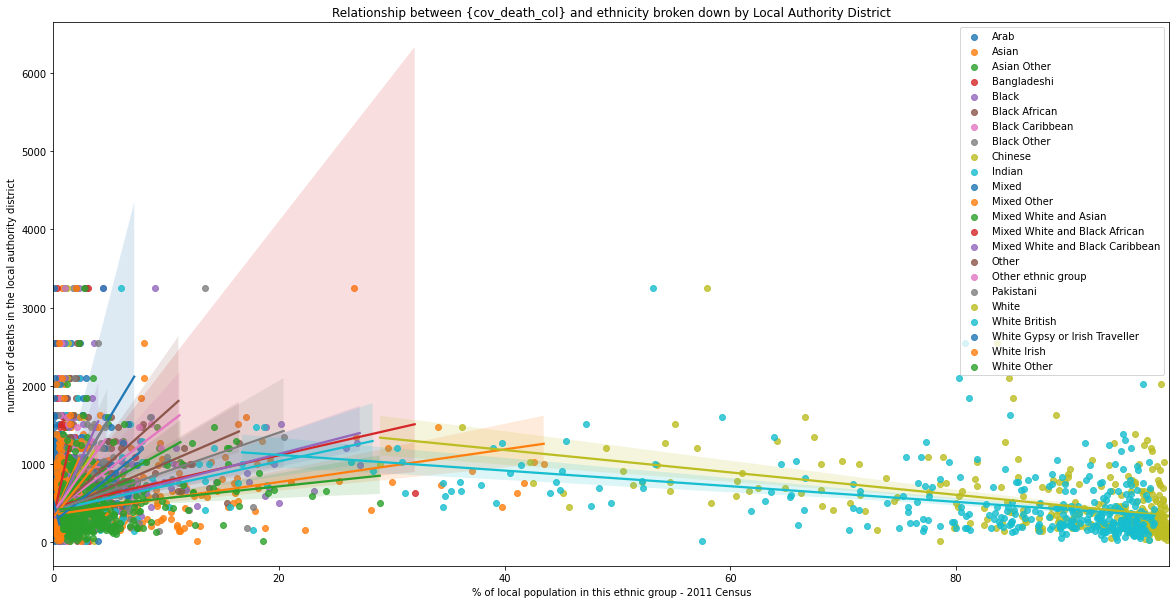

In [88]:
reg_plot(df, "COVID Deaths 2020-06-04")

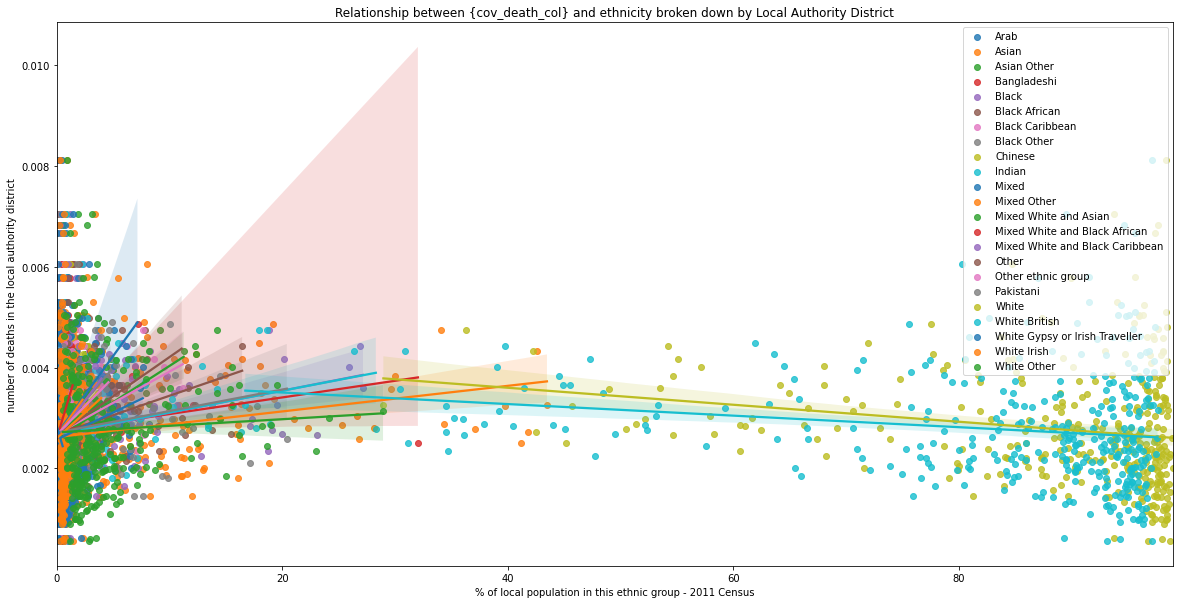

In [89]:
reg_plot(df, "COVID Deaths 2020-06-04 as % of 2011 pop")

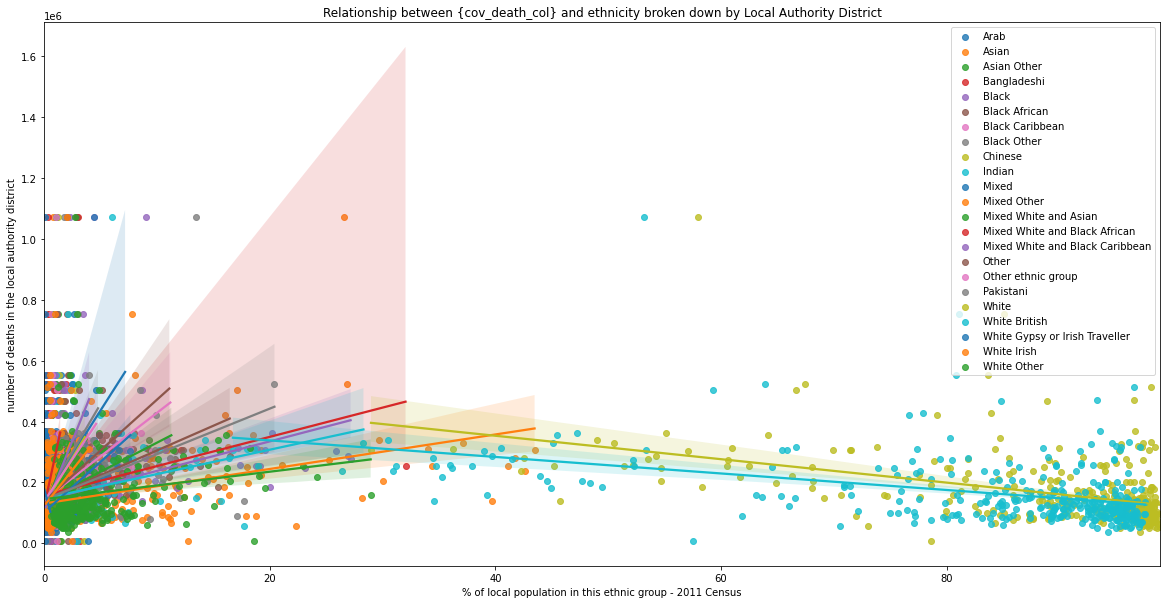

In [90]:
reg_plot(df, "LAD Population")

## Interrelationships

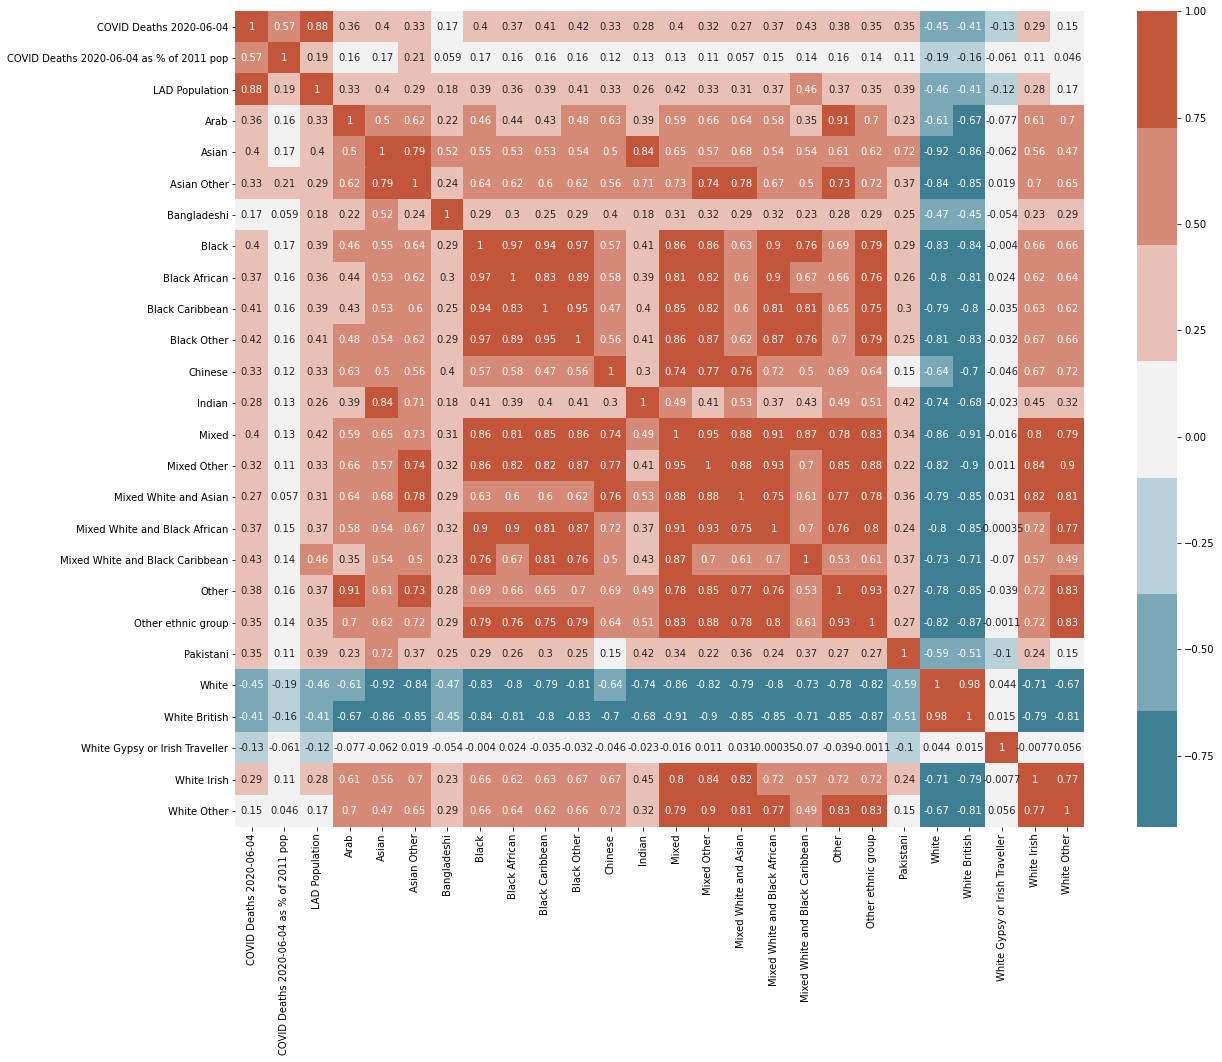

In [57]:
#correlation matrix of relevant variables
plt.figure(figsize=(19, 15))
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
# plt.show()
plt.savefig("../reports/figures/corrmat.png")

# Grouping Ethnicities
Grouping ethnicities based on the [5 broad ethnic groups](https://www.ethnicity-facts-figures.service.gov.uk/ethnic-groups) used by the goverment. However in doing so we are already losing the heterogeneity wthin these broad categories and may be missing the differing impacts within them.  

In [85]:
df_grouped = df.iloc[:,:3].copy() # target data

# sum groups to get total share
df_grouped["White"] = df[['White', 'White British','White Gypsy or Irish Traveller', 'White Irish', 'White Other']].sum(axis=1)
df_grouped["Mixed"] = df[['Mixed White and Black Caribbean','Mixed White and Asian',
                          'Mixed White and Black African', 'Mixed', 'Mixed Other', ]].sum(axis=1)
df_grouped["Black_African_Caribbean"] = df[['Black', 'Black African', 'Black Caribbean', 'Black Other']].sum(axis=1)
df_grouped["Asian"] = df[['Asian', 'Asian Other', 'Bangladeshi','Chinese','Indian', 'Pakistani', ]].sum(axis=1)
df_grouped["Other"] = df[[ 'Arab','Other', 'Other ethnic group', ]].sum(axis=1)

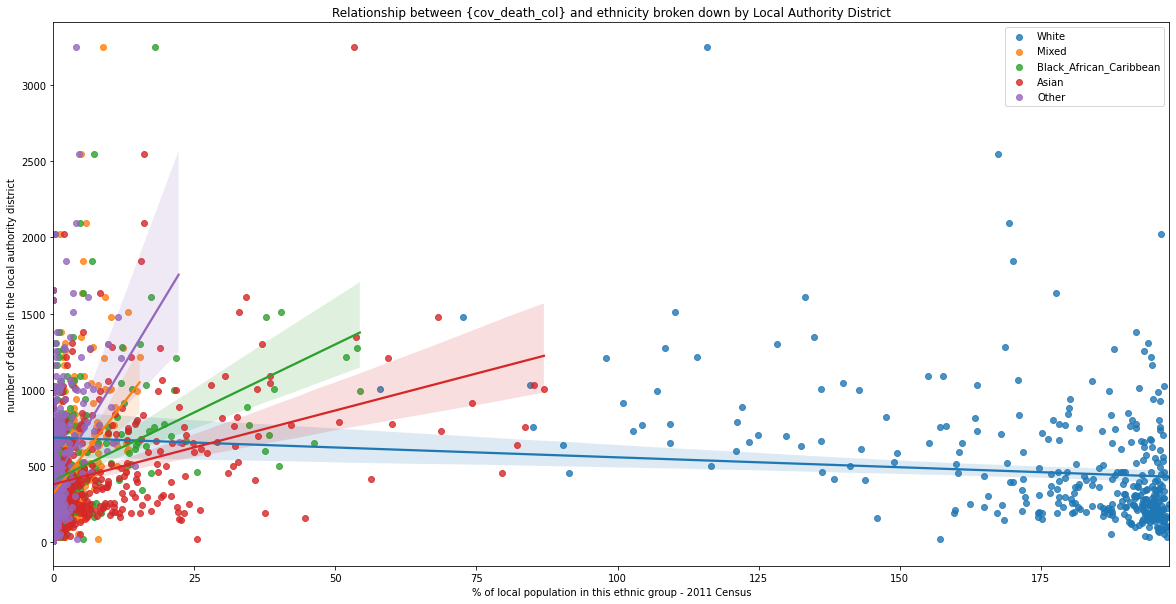

In [91]:
reg_plot(df_grouped,  "COVID Deaths 2020-06-04")

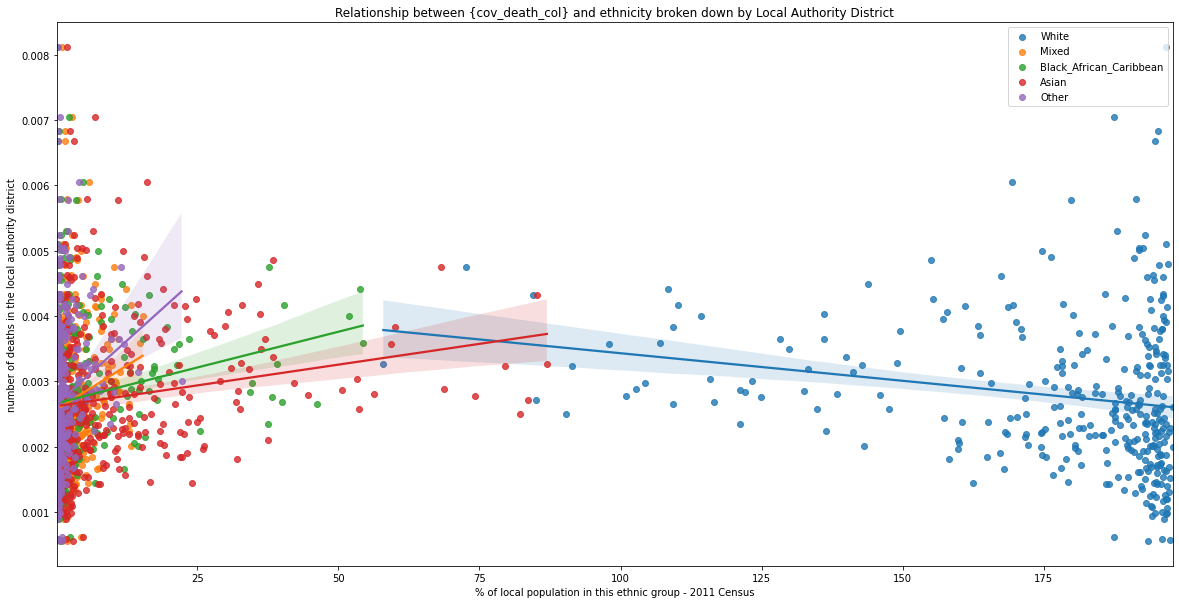

In [96]:
reg_plot(df_grouped, "COVID Deaths 2020-06-04 as % of 2011 pop")

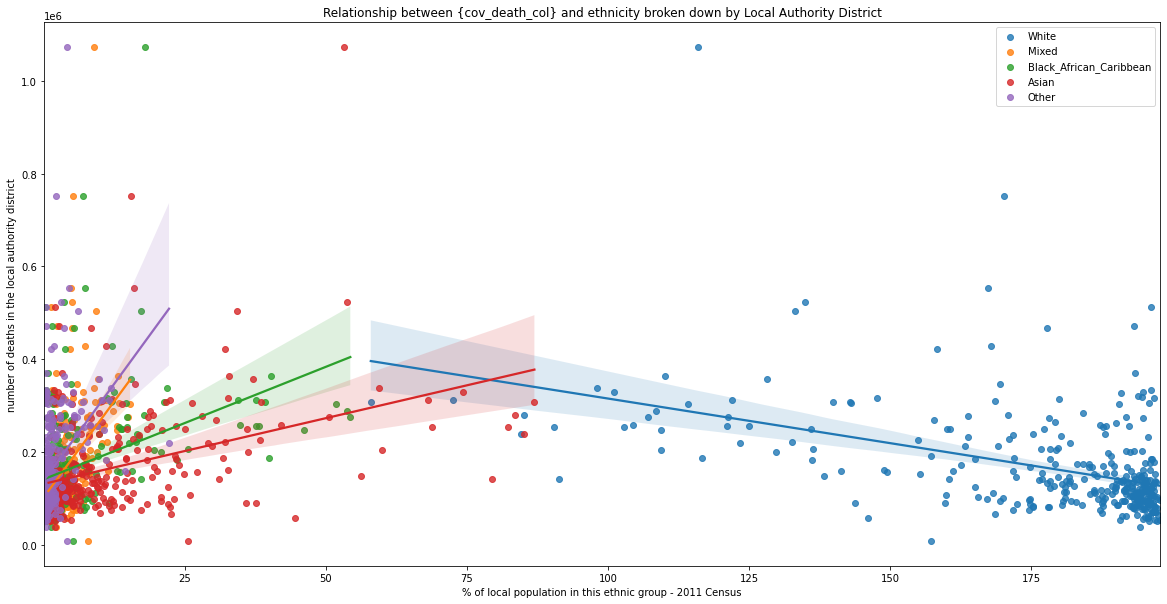

In [95]:
reg_plot(df_grouped, "LAD Population")

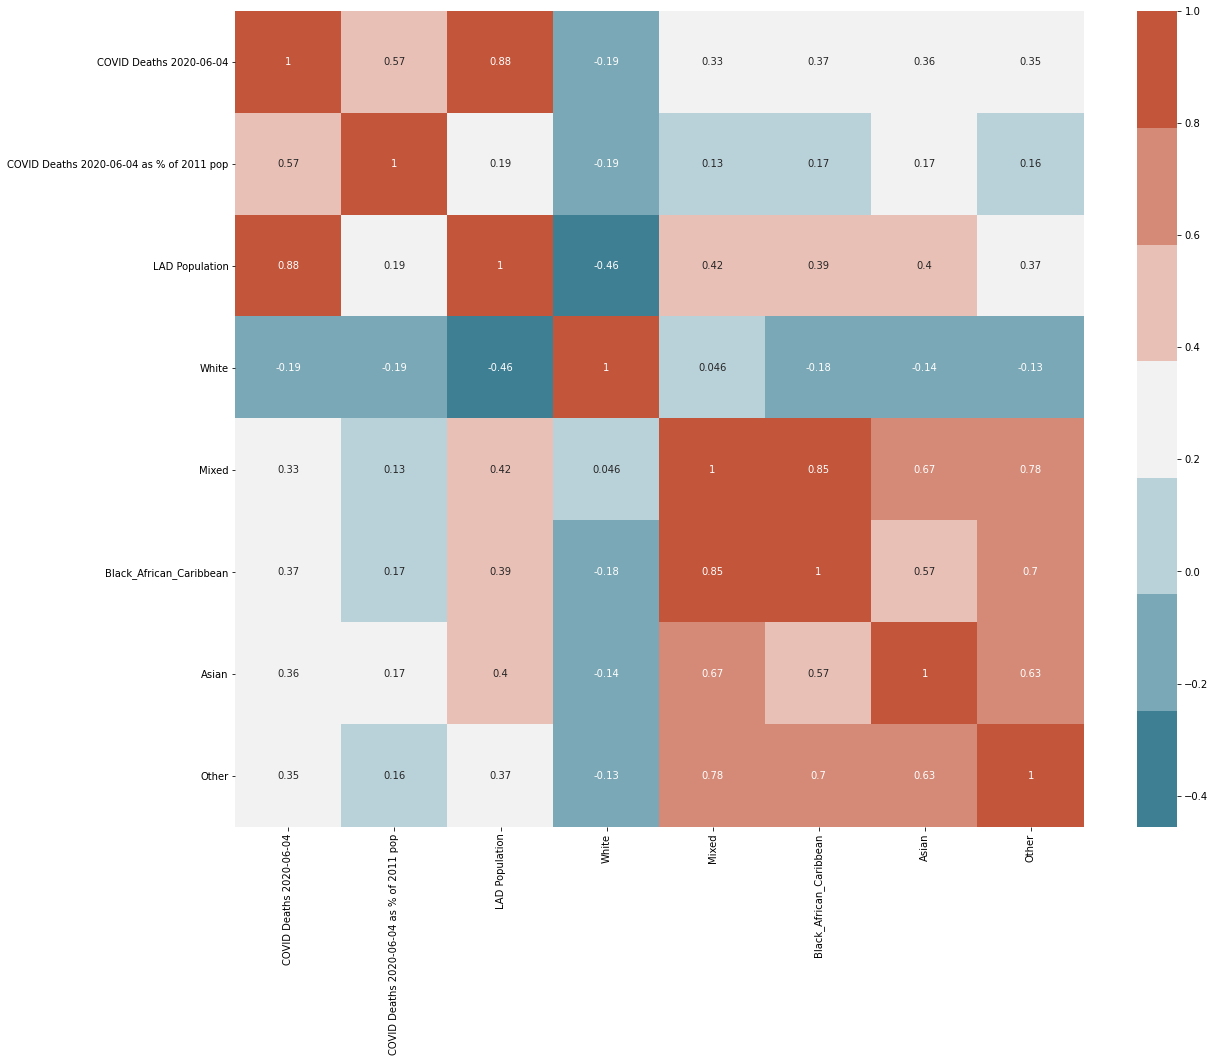

In [94]:
#correlation matrix of relevant variables
plt.figure(figsize=(19, 15))
corrMatrix = df_grouped.corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
# plt.show()
plt.savefig("../reports/figures/corrmat.png")